# Exercise 04) Monte-Carlo Methods

In this exercise we want to make use of the racetrack environment developed in the first homework. 
If you were not able to finish this homework, an adequate environment is provided within this folder.
Feel free to test your version of the environment and compare the results.
Also, be explorative and alternate some configuration parameters to see if they have an impact upon the result.

For the start, please execute the following cells.

In [1]:
import numpy as np
import random
import sys
from solution import RaceTrackEnv
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('dark_background')

WWWWWWWWWWWW
WWWWW-oooooW
WWWWW-oooooW
WWWWW-oooooW
WWWWWWWWWooW
WWWWWWWWWooW
WWWWW+oooooW
WWWWW+oooooW
WWWWW+oooooW
WWWWWWWWWWWW


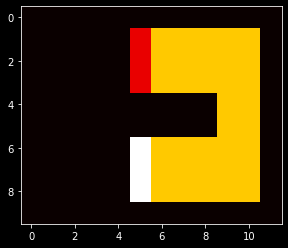

In [2]:
# Build the course
_course_dim = (8, 10)
_inner_wall_dim = (2, 6)

def build_uturn_course(course_dim, inner_wall_dim):
    """
    Build a race track for the u-turn street scenario.
    Start and finish line are placed in the center top and bottom respectively. The course dimension specifications
    do not consider a bounding wall around the track, which is inserted additionally. 

    """
    track = []
    wall_up_bound = course_dim[0]//2 - inner_wall_dim[0] // 2
    wall_bottom_bound = course_dim[0]//2 + inner_wall_dim[0]//2
    street_width = course_dim[1]//2 - inner_wall_dim[1]//2
    # construct course line by line
    for i in range(course_dim[0]):
        if i < wall_up_bound:
            half_street_len = course_dim[1]//2 - 1
            track_row = 'W'*(half_street_len//2+1) + 'W-' + 'o'*(half_street_len-1+half_street_len//2)
        elif  wall_up_bound <= i < wall_bottom_bound:
            track_row = 'W'*street_width + 'W'*inner_wall_dim[1] + 'o'*street_width
        else:
            track_row = 'W'*(half_street_len//2+1) + 'W+' + 'o'*(half_street_len-1+half_street_len//2)
        track.append(track_row)
    # add boundary
    track = ['W'*course_dim[1]] + track + ['W'*course_dim[1]]
    track = ['W'+s+'W' for s in track]
    return track
    
course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
for row in course:
    print(row)
    
pos_map =  track.course  # overlay track course
plt.imshow(pos_map, cmap='hot', interpolation='nearest')
plt.show()

## 1) MC-Based Policy Evaluation

Write a first-visit Monte-Carlo algorithm to evaluate the dummy policy as defined below on the U-turn course. The dummy policy turns the car to the right as soon as it stands in front of a wall. Try to understand how the policy works before you start to code. Actions (accelerations in given directions) are encoded according to the following diagram:

![](Directions_Legend.png)

How can we interprete the state values resulting from the evaluation with first-visit Monte-Carlo?

## 1) Solution

In [ ]:
### Select course and initialize dummy policy

course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
dummy_slow_pi = np.ones([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY]) * 4 

dummy_slow_pi[:track.bounds[0]//2, :, 0 , 0] = 5   # go right
dummy_slow_pi[:track.bounds[0]//2, -2:, 0 , :] = 6 # go bottom left
dummy_slow_pi[-2:, track.bounds[1]//2:, : , 0] = 0 # go top left

pi = dummy_slow_pi

In [ ]:
# initialize the value function
values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY])

# initialize an empty dict to count the number of visits
n_dict = {}

# configuration parameters
gamma = 1 # discount factor
no_episodes = 500 # number of evaluated episodes
no_steps = 2000 # number of allowed timesteps per episode


for e in tqdm(range(no_episodes), position=0, leave=True):
    
    # initialize variables in which collected data will be stored
    states = ??? # list of tuples
    rewards = ??? # list of floats
    visited_states = ??? # set of tuples
    first_visit_list = ??? # list of booleans
    
    # reset environment and start episode
    p, v = track.reset()
    for k in range(no_steps):
        
        # unpack the statee information
        s_y, s_x = p[0], p[1]
        s_vy, s_vx = v[0], v[1]
        state_tuple = s_y, s_x, s_vy, s_vx
        
        # save the momentary state
        states.append(???) 
        
        # check momentary state for first visit
        first_visit_list.append(???)
        visited_states.add(???)
        
        # choose and perform action
        action = track.action_to_tuple(???)
        (p, v), reward, done, _ = track.step(action)
        
        # save received reward
        rewards.append(???)
        
        # terminate the environment if the finish line was passed
        if done: 
            break 
             
    # learn from the collected data
    g = 0  
    for s, r, first_visit in zip(states[???], rewards[???], first_visit_list[???]): # count backwards
        g = ???
        
        if first_visit:
            
            # Count visits to this state in n_list
            n_dict[s] = n_dict.get(s, 0) + ???

            # add new return g to existing value
            values[s] += ???


To visualize the result of the evaluation, plot the state values as a function of **position only** (so that you get a two dimensional representation of the state value) and in the form of a tabular represenation and a heatmap. In order to omit dependence of the velocity dimensions, use the minimum of the value function with respect to the velocities.

In [ ]:
def text_print_pos_map(_pos_map):
    for row in _pos_map:
        print(' '.join(x_size*['{}']).format(*[str(int(r)).zfill(3) for r in row]))
        
def plot_pos_map(_pos_map):
    plt.imshow(???) # use the "hot" colormap and the "nearest" interpolation
    plt.show()

# calculate minimum value with respect to velocities
x_size, y_size = len(course[0]), len(course)
pos_map = np.zeros((y_size, x_size))

for s_x in range(x_size):
    for s_y in range(y_size):
        pos_map[s_y, s_x] = ???
        
text_print_pos_map(pos_map)
plot_pos_map(-pos_map)

## 2) On-Policy $\varepsilon$-Greedy Control

Starting with the previously used turn-right-if-wall dummy policy, write an on-policy Monte-Carlo based first-visit $\varepsilon$-greedy control algorithm to solve the U-turn course. The policy is now stochastic: it does not contain simple action commands for each state, but probabilities for each possible action. Again, please make sure to understand how the stochastic policy works before coding.


Make sure to implement an upper bound for episode length (we suggest a boundary of 200 steps). Why do we need a bound like this? What happens to the state values / state-action values if we increase the bound?

## 2) Solution

In [ ]:
# dummy policy
course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)

dummy_slow_stoch_pi = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 9])

dummy_slow_stoch_pi[  :,   :, :, :, 4] = 1 # set probability of doing nothing to one for every state

# set probability to go right:
dummy_slow_stoch_pi[:track.bounds[0]//2, :, 0 , 0, 5] = 1 
# set probability to do nothing where we want to go right:
dummy_slow_stoch_pi[:track.bounds[0]//2, :, 0 , 0, 4] = 0 

dummy_slow_stoch_pi[:track.bounds[0]//2, -2:, 0 , :, 6] = 1 # probability to go bottom left
dummy_slow_stoch_pi[:track.bounds[0]//2, -2:, 0 , :, 4] = 0 

dummy_slow_stoch_pi[-2:, track.bounds[1]//2:, : , 0, 0] = 1 # probability to go top left
dummy_slow_stoch_pi[-2:, track.bounds[1]//2:, : , 0, 4] = 0 

pi = dummy_slow_stoch_pi                                   

In [ ]:
# initialize action_values and counting dict
action_values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])
n_dict = {}

# configuration parameters
epsilon = 0.1 # exploration probability
gamma = 1 # discount factor
no_episodes = 5000 # number of evaluated episodes
no_steps = 200 # number of evaluated timesteps per episode


track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)

for e in tqdm(range(no_episodes), desc='episode', mininterval=2):
      
    # initialize variables in which collected data will be stored
    action_states = ??? # list of tuples
    rewards = ??? # list of floats
    visited_action_states = set() # set of tuples
    first_visit_list = ??? # list of booleans
    
    pos_map = np.zeros((y_size, x_size)) # initializes a map that can be plotted
    p, v = track.reset()
    for k in range(no_steps):
        s_y, s_x = p[0], p[1]
        s_vy, s_vx = v[0], v[1]
        
        pos_map[s_y, s_x] += 1  # mark the visited position on the map
        
        # execute action (either by following the policy, or by exploring randomly)
        if epsilon < np.random.rand(1):
            action = ???
        else:
            action = ???
        
        # save the action state and check for first visit
        a = track.action_to_tuple(action)
        action_state = track.state_action((p, v), a)
        action_states.append(???)
        ???
        visited_action_states.add(action_state)
        
        # perform action
        (p, v), reward, done, _ = ???
        
        # save received reward
        ???
        
        # terminate the environment if the finish line was passed
        ???
    
    # learn from the collected data
    g = 0   
    for r, a_s, first_visit in zip(rewards[???], action_states[???], first_visit_list[???]): # count backwards
        g = ???
        
        if first_visit:
            
            # Count visits to this state in n_list
            n_dict[a_s] = ???

            # add new return g to existing value
            action_values[a_s] += ???
                        
            # calculate the new action probabilities
            u_best = np.argmax(???)
            pi[a_s[:4]] = epsilon / 9
            pi[a_s[:4]][u_best] = ???
            
    
    # this code fragment is to plot the sampled map, comment out for faster computation
    print('Sample trajectory on learned policy in episode {}:'.format(e))
    pos_map = (pos_map > 0).astype(np.float32)
    pos_map +=  track.course  # overlay track course
    plot_pos_map(pos_map)

Use the code block directly below to test the resulting deterministic greedy policy (several samples are taken in order to show behavior in all different starting positions).

In [ ]:
no_episodes = 10
for e in range(no_episodes):
    
    pos_map = np.zeros((y_size, x_size))
    p, v = track.reset()
    for k in range(200):
        s_y, s_x = p[0], p[1]
        s_vy, s_vx = v[0], v[1]
        
        pos_map[s_y, s_x] += 1  # exploration map
        
        action = ???
        a = track.action_to_tuple(action)
        action_state = track.state_action((p, v), a)

        (p, v), reward, done, _ = ???

        if done:
            break 

    print('Sample trajectory on learned policy in episode {}:'.format(e))
    pos_map = (pos_map > 0).astype(np.int16)
    pos_map +=  track.course  # overlay track course
    plot_pos_map(pos_map)

## 3) Off-Policy $\varepsilon$-Greedy Control

Using the dummy-policy from (2) as a behavior policy, write an off-policy Monte-Carlo algorithm with weighted importance sampling.

Has the result gotten better or worse? Why?

## 3) Solution

In [ ]:
### Dummy Policy
course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
dummy_slow_stoch_pi = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 9])

# as the behavior policy is not alternated, there is no possibility to implement the epsilon parameter later
# hence, we need to implemented it right here
epsilon = 0.1

dummy_slow_stoch_pi[  :,   :, :, :, 4] = 1 - epsilon + epsilon / 9
for i in range(9):
    if i != 4:
        dummy_slow_stoch_pi[  :, :, :, :, i] = epsilon / 9
    
dummy_slow_stoch_pi[:track.bounds[0]//2, :, 0 , 0, 5] = 1-epsilon + epsilon/9
dummy_slow_stoch_pi[:track.bounds[0]//2, :, 0 , 0, 4] = epsilon / 9

dummy_slow_stoch_pi[:track.bounds[0]//2, -2:, 0 , :, 6] = 1-epsilon + epsilon/9
dummy_slow_stoch_pi[:track.bounds[0]//2, -2:, 0 , :, 4] = epsilon / 9

dummy_slow_stoch_pi[-2:, track.bounds[1]//2:, : , 0, 0] = 1-epsilon + epsilon/9
dummy_slow_stoch_pi[-2:, track.bounds[1]//2:, : , 0, 4] = epsilon / 9

behavior_policy = dummy_slow_stoch_pi  

pi = np.copy(behavior_policy)

In [ ]:
# initialize action_values and dict of cumulated WIS weights
action_values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])
c_dict = {}

# configuration parameters
# epsilon = 0.1 was defined within the behavior policy
gamma = 1 # discount factor
no_episodes = 1000 # number of evaluated episodes
no_steps = 200 # number of evaluated timesteps per episode

course = course
track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)

for e in tqdm(range(no_episodes), desc='episode', mininterval=2):
    
    action_states = ??? # list of tuples
    actions = ??? # list of tuples
    rewards = ??? # list of floats
    
    pos_map = np.zeros((y_size, x_size))
    p, v = track.reset()
    for k in range(no_steps):
        s_y, s_x = p[0], p[1]
        s_vy, s_vx = v[0], v[1]
        
        pos_map[s_y, s_x] += 1  # exploration map
        
        if epsilon < np.random.rand(1):
            action = np.argmax(???])
        else:
            action = ???
        
        a = track.action_to_tuple(action)
        action_state = track.state_action((p, v), a) # saves the action_state to be used as an index (all values are positive)
        actions.append(???) # saves the action as it is applied (acceleration can be negative)
        action_states.append(action_state)

        (p, v), reward, done, _ = ???
        
        rewards.append(reward)
        if done:
            ???
    
    # Monte-Carlo WIS Update
    g = ???
    w = ???       
    for r, a_s, applied_action in zip(rewards[???], action_states[???], actions[???]): # count backwards
        g = ???
            
        # Count visits to this state in n_list
        c_dict[a_s] = ???

        # add new return g to existing value
        action_values[a_s] += ???
                        
        # determine greedy policy
        u_best = np.argmax(???)
        pi[a_s[:4]] = 0
        pi[a_s[:4]][u_best] = 1
        
        # check if applied action equals greedy action
        if ??? != track.action_to_tuple(???):
            break
        
        w = ???
    
    # code fragment for plotting      
    pos_map = (pos_map > 0).astype(np.float32)
    pos_map +=  track.course  # overlay track course
    print('Sample trajectory on learned policy in episode {}:'.format(e))
    plot_pos_map(pos_map)

In [ ]:
episodes = 10
for e in range(episodes):
    
    pos_map = np.zeros((y_size, x_size))
    p, v = track.reset()
    for k in range(200):
        s_y, s_x = p[0], p[1]
        s_vy, s_vx = v[0], v[1]
        
        pos_map[s_y, s_x] += 1  # exploration map
        
        action = ???
        
        a = track.action_to_tuple(action)
        action_state = track.state_action((p, v), a)

        (p, v), reward, done, _ = ???

        if done:
            print('Done')
            break 

            
    print('Sample trajectory on learned policy in episode {}:'.format(e))
    pos_map = (pos_map > 0).astype(np.int16)
    pos_map +=  track.course  # overlay track course
    plot_pos_map(pos_map)

## 4) Extra Challenge: A More Complex Course

The course given below poses a substantially harder challenge for Monte-Carlo based algorithms. Why? If you want to try solving it yourself, be aware that it may take much longer until a successful policy is found.

In [ ]:
# Build the course
_course_dim = (8, 10)
_inner_wall_dim = (2, 6)

def build_rect_course(course_dim, inner_wall_dim):
    """
    Build a race track given specifications for the outer cyclic street and inner wall dimensions.
    Start and finish line should be placed in the center top. The course dimension specifications
    do not consider a bounding wall around the track, which must be inserted additionally.
    
    Args:
        course_dim: 2-tuple, (y-dim, x-dim): The size of the track without outer walls.
        inner_wall_dim: 2-tuple (y-dim, x-dim): The size of the inner wall
    
    """
    track = []
    wall_up_bound = course_dim[0]//2 - inner_wall_dim[0] // 2
    wall_bottom_bound = course_dim[0]//2 + inner_wall_dim[0]//2
    street_width = course_dim[1]//2 - inner_wall_dim[1]//2
    # construct course line by line
    for i in range(course_dim[0]):
        if i < wall_up_bound:
            half_street_len = course_dim[1]//2 - 1
            track_row = 'o'*half_street_len + '+W-' + 'o'*(half_street_len-1)
        elif  wall_up_bound <= i < wall_bottom_bound:
            track_row = 'o'*street_width + 'W'*inner_wall_dim[1] + 'o'*street_width
        else:
            track_row = 'o'*course_dim[1]
        track.append(track_row)
    # add boundary
    track = ['W'*course_dim[1]] + track + ['W'*course_dim[1]]
    track = ['W'+s+'W' for s in track]
    return track
    
course = build_rect_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
for row in course:
    print(row)
    
pos_map =  track.course  # overlay track course
plot_pos_map(pos_map)